# Exploratory Data Analysis

Libraries

In [38]:
import os

# data manipulation libraries
import pandas as pd
import numpy as np

# custom project libraries
from utils.wine_review_utils import load_clean_data, RATINGS

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_theme()

In [39]:
# Load the cleaned data
wine_df = load_clean_data()
wine_df.info()
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 98460 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       98460 non-null  object 
 1   variety      98460 non-null  object 
 2   year         98460 non-null  int64  
 3   country      98460 non-null  object 
 4   price        91633 non-null  float64
 5   taster_name  98460 non-null  object 
 6   description  98460 non-null  object 
 7   points       98460 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 6.8+ MB


,winery,variety,year,country,price,taster_name,description,points
0,Nicosia,White Blend,2013,Italy,NaN,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston...",87
1,Quinta dos Avidagos,Portuguese Red,2011,Portugal,15.0,Roger Voss,"This is ripe and fruity, a wine that is smooth...",87
2,Rainstorm,Pinot Gris,2013,US,14.0,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and...",87
3,St. Julian,Riesling,2013,US,13.0,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",87
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87


In [40]:
wine_df.nunique()

winery         14646
variety           50
year              14
country           15
price            366
taster_name       20
description    98460
points            21
dtype: int64

## Univariate Analysis

### Points

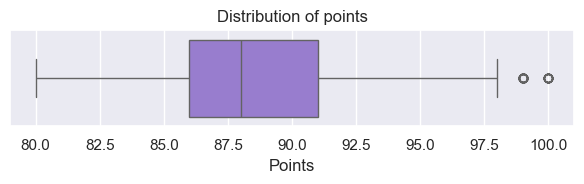

In [41]:
# box plot of points
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.boxplot(wine_df, x='points', orient='h', color='mediumpurple')
ax.set_title('Distribution of points')
ax.set_xlabel('Points')
plt.tight_layout()
plt.show()

### Price

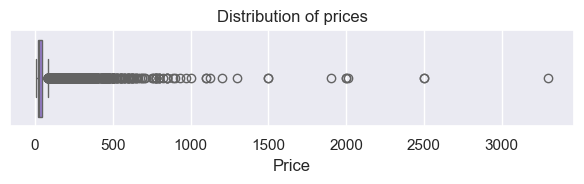

In [42]:
# box plot of price
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.boxplot(wine_df, x='price', orient='h', color='mediumpurple')
ax.set_title('Distribution of prices')
ax.set_xlabel('Price')
plt.tight_layout()
plt.show()

In [97]:
# extreme price
price_state = wine_df.price.describe()
iqr = price_state['75%'] - price_state['25%']
extreme = price_state['75%'] + 1.5 * iqr
extreme

85.5

In [ ]:
# percent of wines below extreme price
wine_df.query('price < @extreme').shape[0]/wine_df.price.notna().sum()

0.949821570831469

In [102]:
# average rating of wines above extreme price
wine_df.query('price < @extreme').points.describe(), wine_df.query('price > @extreme').points.describe()

(count    87035.000000
 mean        88.328891
 std          2.997208
 min         80.000000
 25%         86.000000
 50%         88.000000
 75%         91.000000
 max        100.000000
 Name: points, dtype: float64,
 count    4598.000000
 mean       92.550022
 std         2.591128
 min        81.000000
 25%        91.000000
 50%        93.000000
 75%        94.000000
 max       100.000000
 Name: points, dtype: float64)

### Year

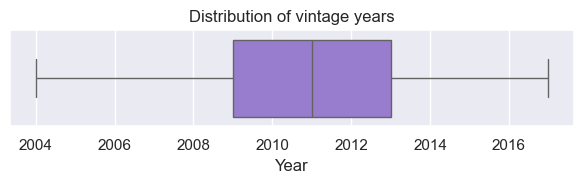

In [43]:
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.boxplot(wine_df, x='year', orient='h', color='mediumpurple')
ax.set_title('Distribution of vintage years')
ax.set_xlabel('Year')
plt.tight_layout()
plt.show()

In [44]:
wine_df.year.describe()

count    98460.000000
mean      2010.957181
std          2.980644
min       2004.000000
25%       2009.000000
50%       2011.000000
75%       2013.000000
max       2017.000000
Name: year, dtype: float64

### Variety

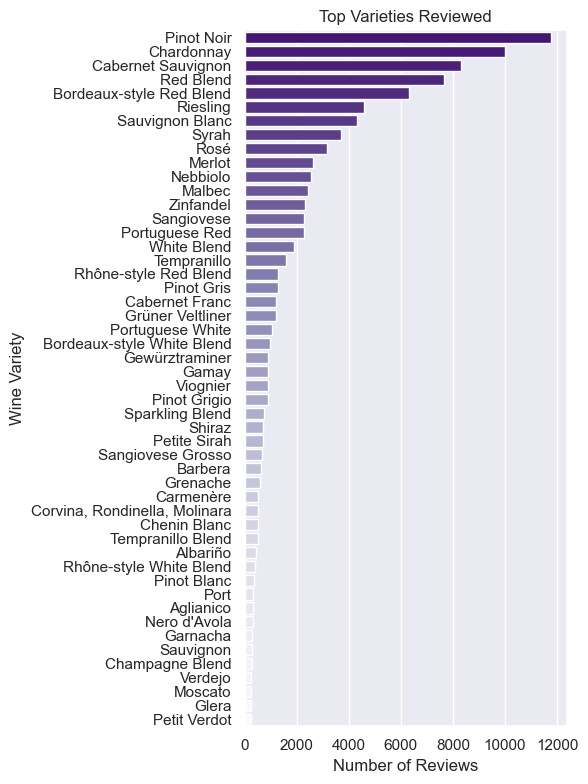

In [45]:
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(wine_df.variety.value_counts().sort_values(ascending=False).reset_index(), x='count', y='variety', hue='variety', dodge=False, palette='Purples_r')
ax.set_title('Top Varieties Reviewed')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Wine Variety')
plt.tight_layout()
plt.show()

### Country

In [46]:
reviews_by_country = wine_df.country.value_counts().reset_index().replace({'US':'United States of America'}).sort_values('count', ascending=False).set_index('country')
reviews_by_country

,count
country,
United States of America,45394
France,17193
Italy,12634
Spain,4081
Portugal,4005
Chile,3650
Argentina,2972
Austria,2172
Germany,1787


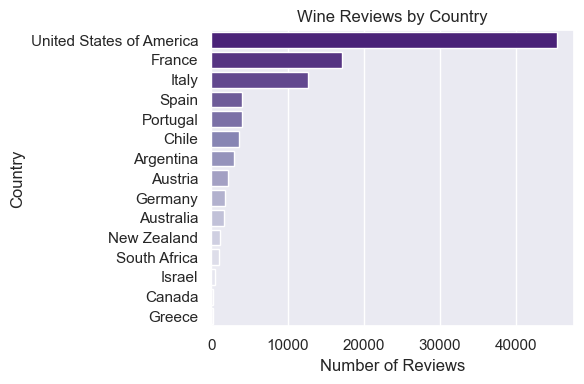

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(reviews_by_country, x='count', y='country', hue='country', dodge=False, palette='Purples_r')
ax.set_title('Wine Reviews by Country')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Country')
plt.tight_layout()
plt.show()

In [48]:
import geopandas as gpd
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

# Natural Earth download page
ne_base_url = 'https://naciscdn.org/naturalearth/10m/cultural/'

# local directory for downloaded files
local_path = 'data'

# download the selected file from Natural Earth if it has not yet been downloaded
def ne_load(file, url=ne_base_url, path=local_path):
  target = os.path.join(path,file.replace('.zip', ''))

  # download the file if necessary
  if not os.path.exists(target):
    zipurl = url+file
    print(zipurl)
    with urlopen(zipurl) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(target)
  
  # make sure the file exists
  assert os.path.exists(target)

  # return the file as a panda frame
  return gpd.read_file(target)


# the columns to load in the DataFrame
ne_cols = ['SOVEREIGNT', 'ADMIN', 'GEOUNIT', 'TYPE', 'NAME', 'NAME_LONG', 'ABBREV', 'FORMAL_EN', 'NAME_SORT', 'ISO_A2_EH', 'CONTINENT', 'SUBREGION', 'REGION_UN', 'geometry']

# helper to load countries shapes
load_countries = lambda path=local_path: ne_load('ne_10m_admin_0_map_units.zip', path=path)[ne_cols]

In [49]:
import contextily as cx

def plot_df(df, column=None, ax=None, alpha=0.5, crs=3857):
  "Plot based on the `geometry` column of a GeoPandas dataframe"
  df = df.copy()
  df.to_crs(epsg=crs)

  if ax is None:
    _, ax = plt.subplots(figsize=(8,8))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  df.plot(
    ax=ax,
    alpha=alpha, edgecolor='k',
    column=column, # categorical=True,
    legend=True, #legend_kwds={'loc': 'upper left'},
    scheme='quantiles',
    figsize=(15,10),
    cmap='OrRd',
    missing_kwds={
      'color': 'lightgrey'
    }
  )
  
  # west, south, east, north = bbox = df.total_bounds
  # img, ext = cx.bounds2raster(west, south, east, north, 'world_watercolor.tif', ll=True)
  # cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)

def plot_shape(shape, ax=None, crs=3857):
  df = gpd.GeoDataFrame({'geometry': [shape]}, crs='ESPG:4326')
  plot_df(df, ax=ax, crs=crs)

In [50]:
countries = load_countries()[['SOVEREIGNT', 'ADMIN', 'TYPE', 'GEOUNIT', 'NAME', 'NAME_LONG', 'FORMAL_EN', 'NAME_SORT', 'ISO_A2_EH', 'geometry']].set_index('GEOUNIT')
countries.head()

,SOVEREIGNT,ADMIN,TYPE,NAME,NAME_LONG,FORMAL_EN,NAME_SORT,ISO_A2_EH,geometry
GEOUNIT,,,,,,,,,
Indonesia,Indonesia,Indonesia,Sovereign country,Indonesia,Indonesia,Republic of Indonesia,Indonesia,ID,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
Malaysia,Malaysia,Malaysia,Sovereign country,Malaysia,Malaysia,Malaysia,Malaysia,MY,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
Chile,Chile,Chile,Sovereign country,Chile,Chile,Republic of Chile,Chile,CL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
Bolivia,Bolivia,Bolivia,Sovereign country,Bolivia,Bolivia,Plurinational State of Bolivia,Bolivia,BO,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
Peru,Peru,Peru,Sovereign country,Peru,Peru,Republic of Peru,Peru,PE,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [51]:
countries.loc[reviews_by_country.index, 'count'] = reviews_by_country['count']
# countries.loc[countries['count'].isna(), 'count'] = 0
countries.drop('Antarctica', inplace=True)
countries[['geometry', 'count']]

,geometry,count
GEOUNIT,,
Indonesia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",NaN
Malaysia,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",NaN
Chile,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",3650.0
Bolivia,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",NaN
Peru,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",NaN
...,...,...
Palmyra Atoll,"POLYGON ((-162.06086 5.88719, -162.05761 5.882...",NaN
Kingman Reef,"POLYGON ((-162.40018 6.44514, -162.38528 6.445...",NaN
Bajo Nuevo Bank (Petrel Is.),"POLYGON ((-79.98929 15.79495, -79.98782 15.796...",NaN


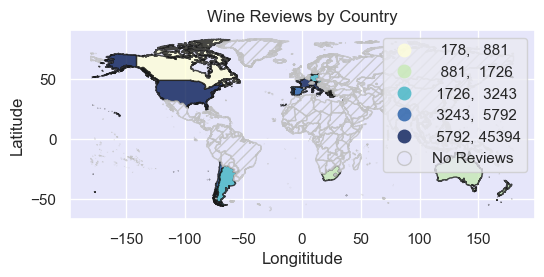

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap, Normalize

fig, ax = plt.subplots(1,1,figsize=(6,4),)
countries.plot(
  column='count', # categorical=True,
  ax=ax, #cax=cax,
  alpha=.8, edgecolor='k',
  scheme = 'QUANTILES',
  legend=True, #legend_kwds={'label': 'Wine Reviews by Country', 'orientation': 'vertical'},
  legend_kwds={'fmt':'{:.0f}'},
  # scheme='quantiles',
  cmap='YlGnBu', #norm=norm,
  figsize=(10,6),
  # cmap=cmap,norm=norm,
  missing_kwds={ 'label':'No Reviews', 'color':'lavender', 'edgecolor':'silver', 'hatch':'///'},
  
)
plt.xlabel('Longititude')
plt.ylabel('Latitude')
plt.title('Wine Reviews by Country')
plt.grid(True)
# ax.set_facecolor((251/255,238/255,255/255))
ax.set_facecolor('lavender')
# cx.add_basemap(ax, crs=countries.crs, source=cx.providers.CartoDB.Positron)

### Taster

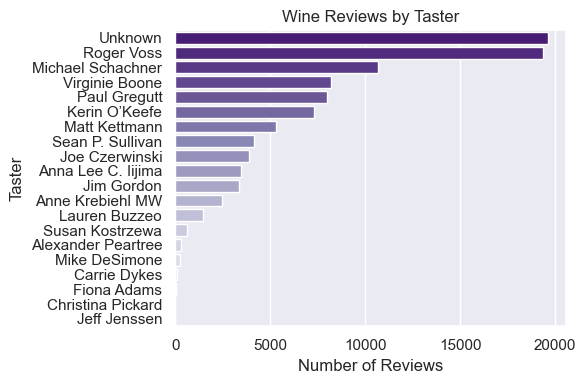

In [53]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(wine_df.taster_name.value_counts().sort_values(ascending=False).reset_index(), x='count', y='taster_name', hue='taster_name', dodge=False, palette='Purples_r')
ax.set_title('Wine Reviews by Taster')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Taster')
plt.tight_layout()
plt.show()

## Multivariate Analysis

### Histograms by groups

In [74]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.pylab import setp

# sort field by review count in descending order
top = lambda field, df=wine_df: df.groupby(field).count()['description'].sort_values(ascending=False).index

def reviews_by(field, values, title, df=wine_df, x='points', orient='v'):
  """"
  ""Plot the distribution of reviews by field and value.
  # field: the field to plot
  # values: the values to plot
  # df: the dataframe to plot
  # x: the field to plot on the x axis
  # orient: the orientation of the plot (v or h)
  """
  fig, ax = plt.subplots(len(values),2, figsize=(6, 1*len(values)), sharex=True, gridspec_kw={'width_ratios':[1, 3]})

  # Create a list to hold the subplots
  axes = [ax[row][col] for row in range(len(values)) for col in range(2)]

  xaxis = sorted(np.unique(df[x]))

  for i, value in enumerate(values):
    # reviews for the value
    value_reviews = df.query(f'{field} == "{value}"')

    # add text elements
    ax_text = axes[i*2]
    ax_text.text(0.1, .65, value, fontsize='medium', fontname='Sathu')
    ax_text.text(0.125, 0.4, f'{value_reviews.points.mean():.1f} average', fontsize='x-small', color='gray',fontname='Arial Unicode MS')
    ax_text.text(0.125, 0.2, f'{value_reviews.points.count()/1000:.1f}k reviews', fontsize='x-small', color='gray', fontname='Arial Unicode MS')
    ax_text.axis('off')  # Hide axes for the text box
    
    # Plot histogram and density function
    ax_chart = axes[i*2 + 1]
    review_counts = value_reviews[x].value_counts(sort=True).reset_index()
    if orient == 'h':
      # show top 5 wines by reviewer
      sns.barplot(review_counts.iloc[:5,:],x='count', y=x, hue='count', palette='Purples', 
                  legend=False, ax=ax_chart, width=1, hue_norm=Normalize(0, review_counts['count'].max()))
      ax_chart.set_xticks([])
      ax_chart.set_xlabel(None)
      ax_chart.set_ylabel(None)
      ax_chart.set_xlim(0, 5000)
      ax_chart.set_yticks(review_counts.index[:5])
    else:
      # show distribution plot, like points, by wine variety
      X = pd.DataFrame(index=pd.Series(xaxis, name=x))
      X['count'] = 0
      X.loc[review_counts.set_index(x).index, 'count'] = review_counts.set_index(x)['count']
      # print(X)
      sns.barplot(X.reset_index(),x=x,y='count',hue='count', palette='Purples', 
                  legend=False, ax=ax_chart, width=1, orient=orient)
      ax_chart.set_yticks([])
      ax_chart.set_ylabel(None)
      # ax_chart.set_xticks(sorted(review_counts.set_index(x).sort_index().index.to_list()))
      ax_chart.set_facecolor('white')
    sns.despine(ax=ax_chart)
    
  if orient == 'v':
    # format the x axis in bottom chart
    idx = 2*len(values) - 1
    # axes[idx].set_axis_on()
    axes[idx].set_xlabel(None)
    # axes[idx].set_ylabel(None)
    # axes[idx].set_yticks([])
    # print(review_counts.set_index(x).sort_index().index)
    axes[idx].set_xticks(axes[idx].get_xticks())
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), fontsize='x-small')
  else:
    # format the wine varities in y-axis of all plots
    for i in range(len(values)):
      idx = 2*i+1
      axes[idx].set_yticklabels(axes[idx].get_yticklabels(), fontsize='x-small')

  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

**Histogram of Reviews by Points for Varieties**

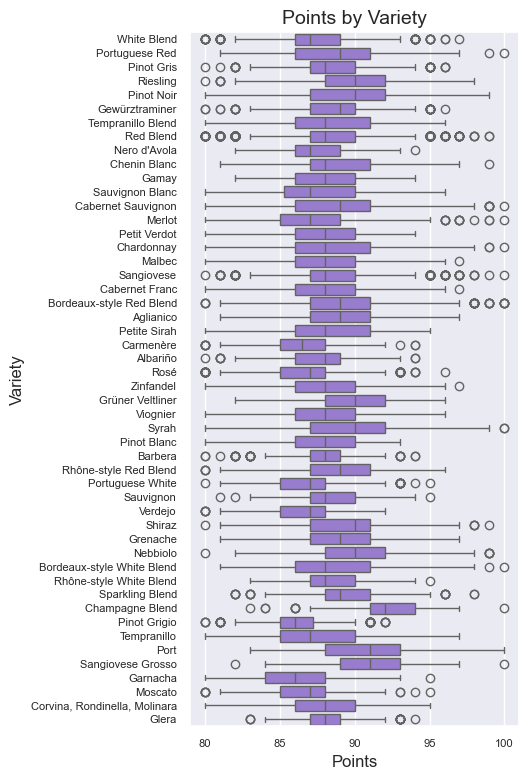

In [55]:
plt.figure(figsize=(6, 8))
sns.boxplot(data=wine_df, x='points', y='variety', color = 'mediumpurple')
plt.title('Points by Variety', fontsize = 14)
plt.xlabel('Points')
plt.tight_layout()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Variety')
plt.show()

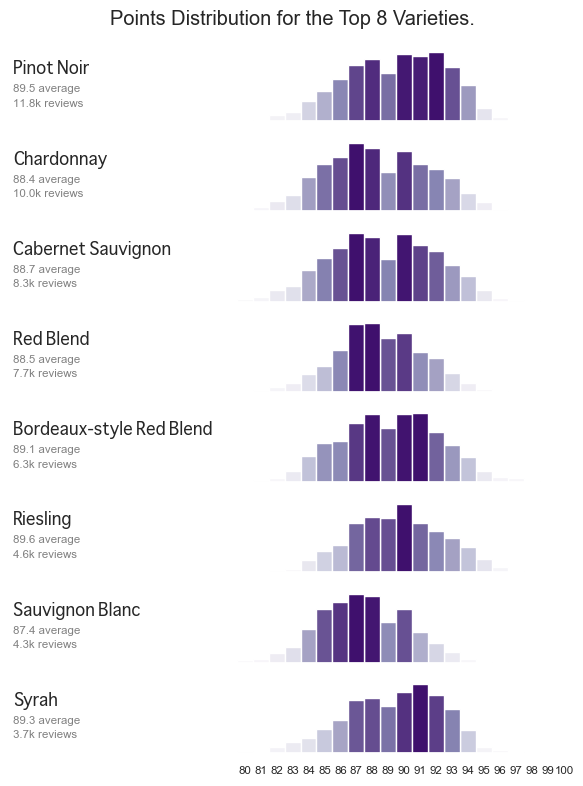

In [75]:
reviews_by('variety', top('variety')[:8], 'Points Distribution for the Top 8 Varieties.')

**Histogram of Reviews by Points for Reviewers**

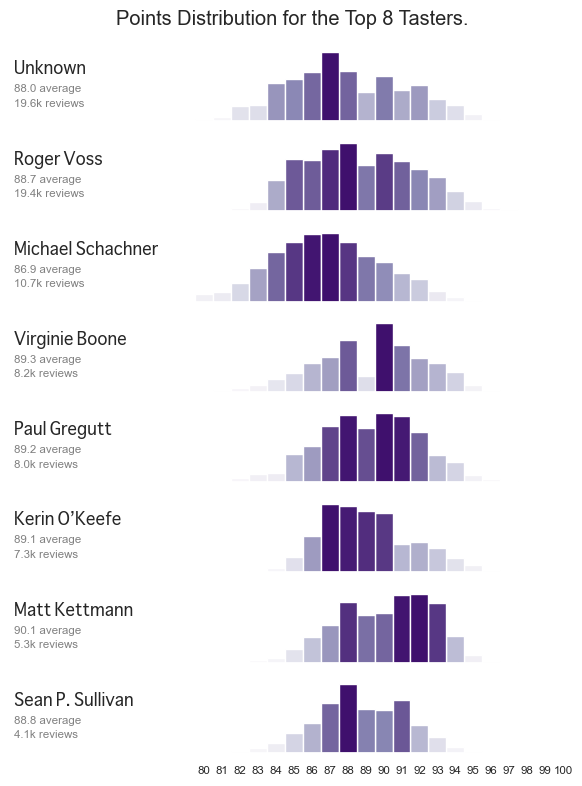

In [76]:
reviews_by('taster_name', top('taster_name')[:8], 'Points Distribution for the Top 8 Tasters.')

**Histogram of Reviews by Points for Wineries**

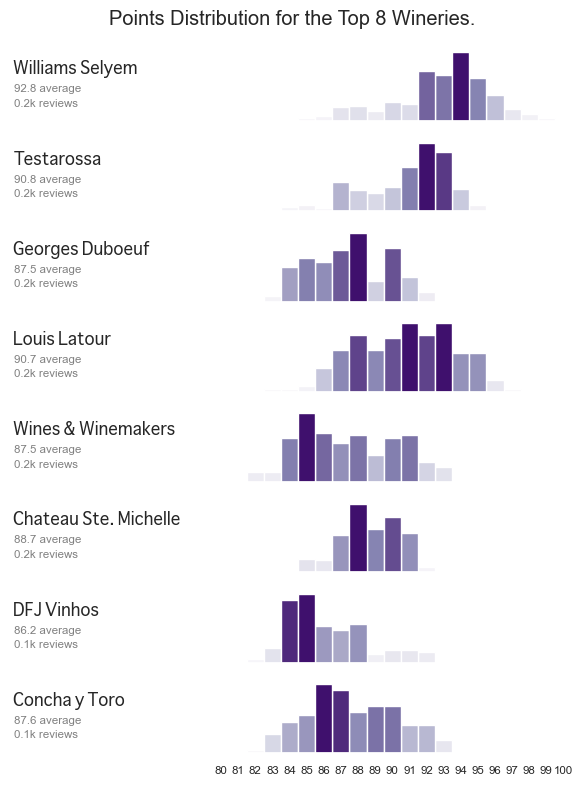

In [77]:
reviews_by('winery', top('winery')[:8], 'Points Distribution for the Top 8 Wineries.')

**Histogram of Reviews by Points for Countries**

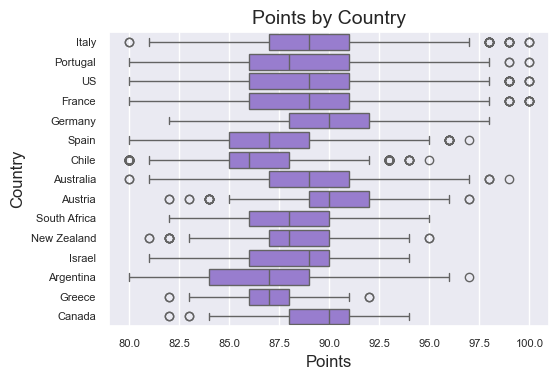

In [78]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=wine_df, x='points', y='country', color = 'mediumpurple')
plt.title('Points by Country', fontsize = 14)
plt.xlabel('Points')
plt.tight_layout()
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Country')
plt.show()

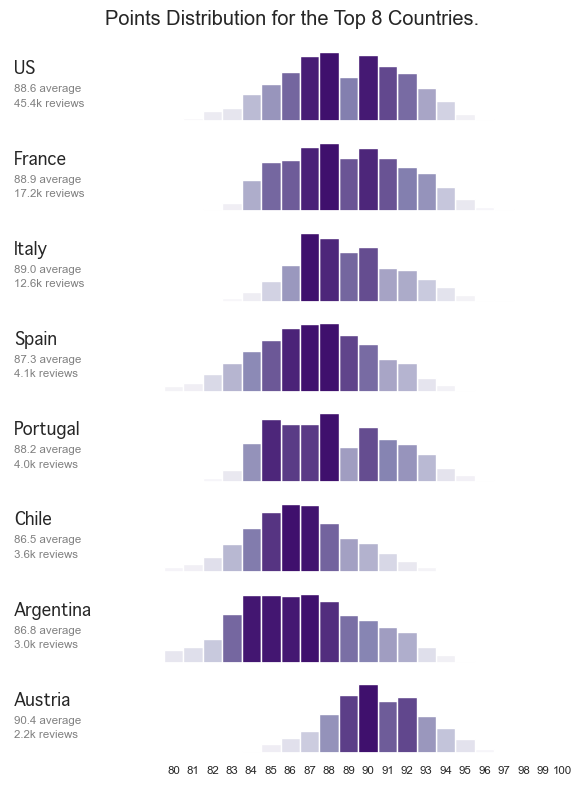

In [79]:
reviews_by('country', top('country')[:8], 'Points Distribution for the Top 8 Countries.')

**Relationship between Price and Points**

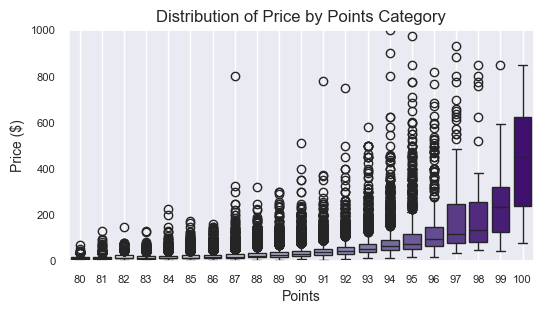

In [80]:
plt.figure(figsize=(6,3))
sns.boxplot(x = 'points', y = 'price', palette = 'Purples', hue='points', data = wine_df, native_scale=False, legend=None)
plt.title("Distribution of Price by Points Category", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Price ($)",fontsize=10)
plt.ylim(0, 1000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

#### Conclusion
`Winery` appears to be a better predictor of `points` than other fields, explaining why blind tasting is so important.

### Price-Points-Year Relationship

In [81]:
wine_corr = wine_df.select_dtypes(np.number).corr()
wine_corr

,year,price,points,review_len
year,1.000000,-0.083433,0.044556,-0.054963
price,-0.083433,1.000000,0.412988,0.250450
points,0.044556,0.412988,1.000000,0.575862
review_len,-0.054963,0.250450,0.575862,1.000000


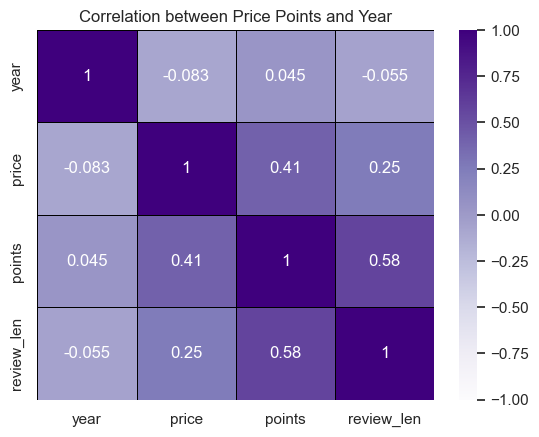

In [82]:
sns.heatmap(wine_corr, annot=True, vmin=-1.0, vmax=1.0, linewidths=0.5, linecolor='black', cmap='Purples')
plt.title("Correlation between Price Points and Year", fontsize=12)
plt.show()

#### Conclusion
There is a clear relationship between the points a wine gets, and the expected price for the wine. However the age of wine appears does not appear to correlate to points or price.

### Taster-Point relationship

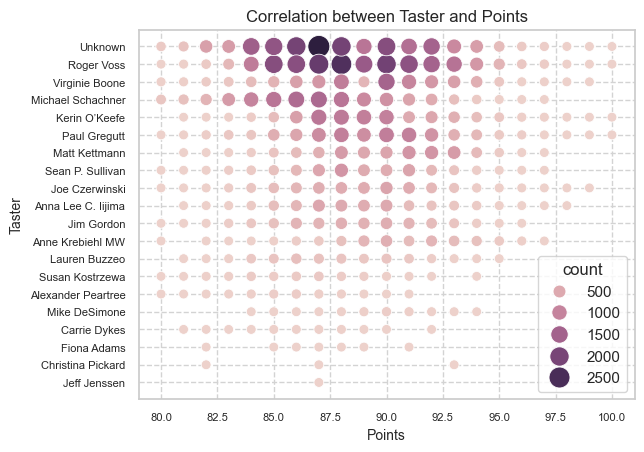

In [83]:
sns.set_style("whitegrid", {'grid.color': 'lightgray', 'grid.linestyle': '--', 'grid.linewidth': .6})
sns.scatterplot(
  wine_df.groupby(['taster_name', 'points'])[['description']].count().reset_index().rename(columns={'description': 'count'}).sort_values('count', ascending=False), 
  x='points', y='taster_name', size='count', hue='count', sizes=(50, 250)
)
plt.title("Correlation between Taster and Points", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Taster",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


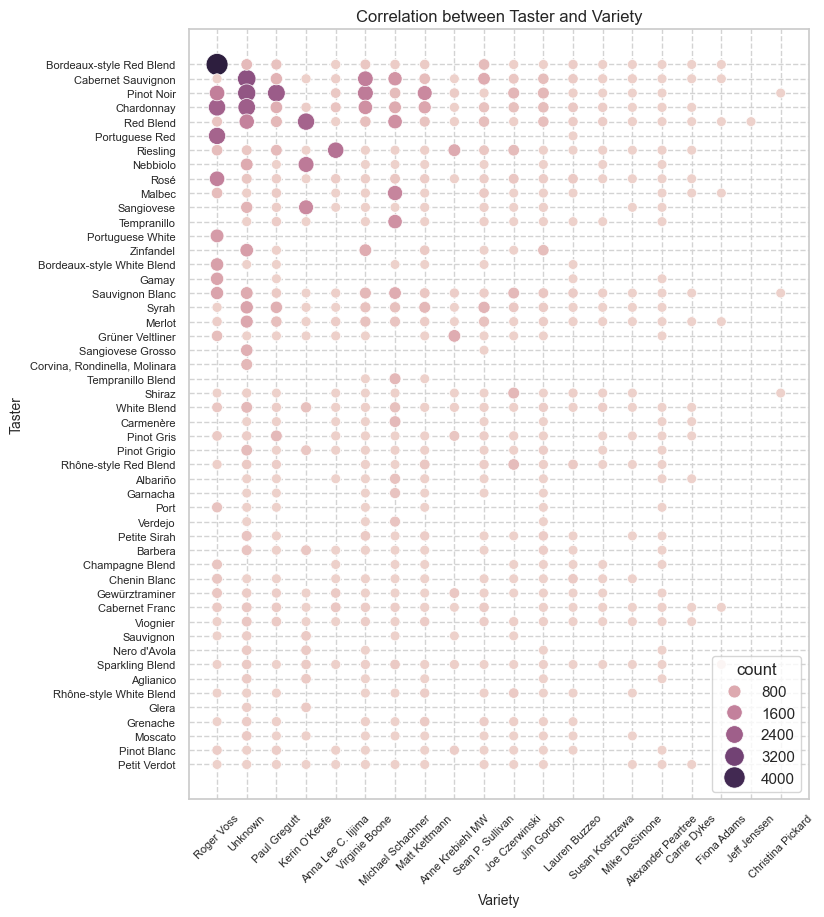

In [84]:
fig = plt.figure(figsize=(8, 10))
sns.scatterplot(wine_df.groupby(['taster_name', 'variety'])[['description']].count().reset_index().rename(columns={'description': 'count'}).sort_values('count', ascending=False), y='variety', x='taster_name', size='count', hue='count', linewidths=0.5, sizes=(50, 250))
plt.title("Correlation between Taster and Variety", fontsize=12)
plt.xlabel("Variety",fontsize=10)
plt.ylabel("Taster",fontsize=10)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.show()

sns.set_theme()

#### Conslusion

- Most wines reviewed are mid-range between 85 and 90 points as expected. Most reviewers span broad range of points. Does not appear to be bias from reviewer.
- The top $6$ most reviewed wines are reviewed by the top $4$ reviewers, which include **Unknown**. This indicates that reviewers build an expertise and tend to specialize.

### Country-Price-Point relationship

**Mean Price and Points vs total volume of reviews by country**

In [85]:
by_country_stats = wine_df.groupby('country').aggregate({'points': ['mean', 'count'], 'price': 'mean'}).sort_values(('points', 'count'), ascending=False)
by_country_stats

points             price
                   mean  count       mean
country                                  
US            88.649205  45394  37.525433
France        88.868842  17193  41.925863
Italy         88.958208  12634  45.159032
Spain         87.310953   4081  28.019078
Portugal      88.222722   4005  23.842181
Chile         86.517260   3650  21.090934
Argentina     86.754711   2972  25.263624
Austria       90.375691   2172  31.806044
Germany       90.003358   1787  43.675614
Australia     88.790086   1634  37.467702
New Zealand   88.393499   1169  27.405453
South Africa  88.203203    999  24.793028
Israel        88.508557    409  31.838791
Canada        89.382514    183  33.478022
Greece        87.044944    178  24.257143

In [103]:
by_country_stats.reset_index()

country     points             price
                       mean  count       mean
0             US  88.649205  45394  37.525433
1         France  88.868842  17193  41.925863
2          Italy  88.958208  12634  45.159032
3          Spain  87.310953   4081  28.019078
4       Portugal  88.222722   4005  23.842181
5          Chile  86.517260   3650  21.090934
6      Argentina  86.754711   2972  25.263624
7        Austria  90.375691   2172  31.806044
8        Germany  90.003358   1787  43.675614
9      Australia  88.790086   1634  37.467702
10   New Zealand  88.393499   1169  27.405453
11  South Africa  88.203203    999  24.793028
12        Israel  88.508557    409  31.838791
13        Canada  89.382514    183  33.478022
14        Greece  87.044944    178  24.257143

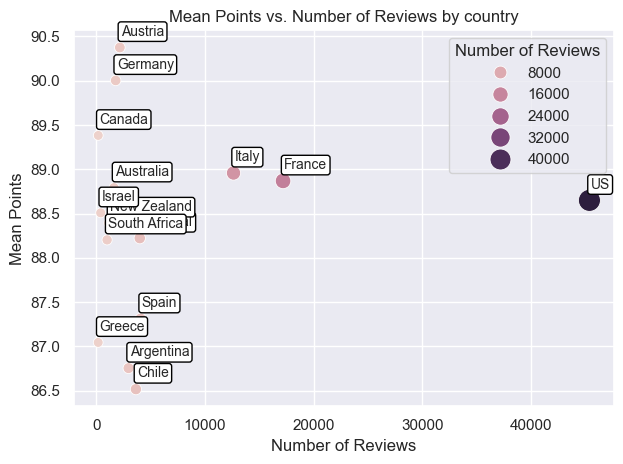

In [ ]:
ax = sns.scatterplot(by_country_stats, x=('points','count'), y=('points', 'mean'), hue=('points','count'), size=('points','count'), sizes=(50, 250))
# Annotate each point with its label
for i, row in by_country_stats.reset_index().iterrows():
    # ax.set_ylim(.0, .20)
    ax.text(row[('points','count')]+100, row[('points', 'mean')]+.1, row['country'].values[0], fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
            horizontalalignment='left', verticalalignment='bottom')
plt.title('Mean Points vs. Number of Reviews by Country')
plt.xlabel('Number of Reviews')
plt.ylabel('Mean Points')
plt.legend(title='Number of Reviews')
plt.tight_layout()
plt.show()

#### Conclusion
- Top $3$ countries reviewed have similar averages just belo $89$, with the less reviewed ones rating slightly higher within $0.5$ points.
- Number of reviews per country does not appear to be a predictor of quality
- The $3$ top rated countries have less than $2,500$ reviews.

### Description-Points relationship

In [87]:
#  calculate the length of the reviews
wine_df['review_len'] = wine_df.description.str.len()

# define a mapping for wine ratings
ratings_map = {points: rating for rating, points_range in RATINGS for points in points_range}

# create a new column for ratings based on the points
wine_df['rating'] = wine_df.points.map(ratings_map)

wine_df.head()

,winery,variety,year,country,price,taster_name,description,points,review_len,rating
0,Nicosia,White Blend,2013,Italy,NaN,Kerin O’Keefe,"Aromas include tropical fruit, broom, brimston...",87,172,very good
1,Quinta dos Avidagos,Portuguese Red,2011,Portugal,15.0,Roger Voss,"This is ripe and fruity, a wine that is smooth...",87,227,very good
2,Rainstorm,Pinot Gris,2013,US,14.0,Paul Gregutt,"Tart and snappy, the flavors of lime flesh and...",87,186,very good
3,St. Julian,Riesling,2013,US,13.0,Alexander Peartree,"Pineapple rind, lemon pith and orange blossom ...",87,199,very good
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,249,very good


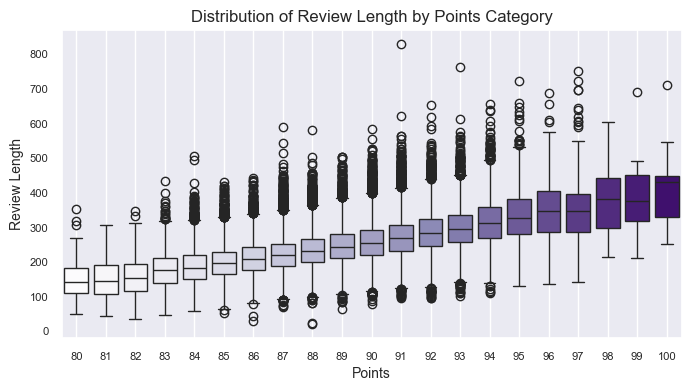

In [88]:
plt.figure(figsize=(8,4))
sns.boxplot(x = 'points', y = 'review_len', palette = 'Purples', hue='points', data = wine_df, native_scale=False, legend=None)
plt.title("Distribution of Review Length by Points Category", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Review Length",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

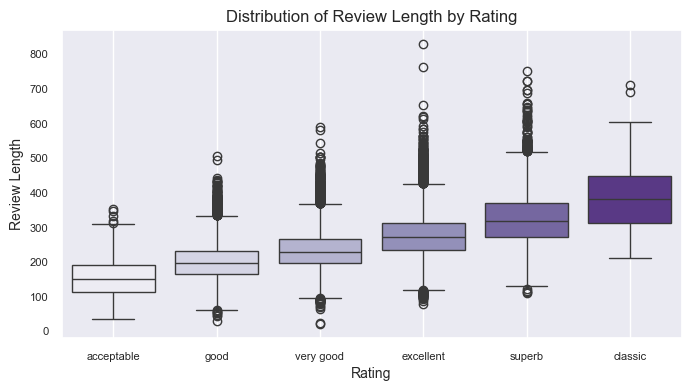

In [89]:
rating_order = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']

plt.figure(figsize=(8,4))
sns.boxplot(x = 'rating', y = 'review_len', palette = 'Purples', hue='rating', data = wine_df, native_scale=False, legend=None, order=rating_order, hue_order=rating_order)
plt.title("Distribution of Review Length by Rating", fontsize=12)
plt.xlabel("Rating",fontsize=10)
plt.ylabel("Review Length",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

#### Conclusion
- Review length appears to be a predictor of points. Likely, the reviewer may require more words to describe what makes highly rated wines remarkable.
- Ratings appear to have less overlap than points. It may be easier to train classifiers on fewer `ratings` than `points`.

### Variety-Points-Review Count relationship

In [90]:
by_variety = wine_df.groupby('variety').agg({'points': ['mean', 'max'],'price': ['mean', 'max'], 'description': ['count']})
by_variety.reset_index()

variety     points            price          \
                                        mean  max        mean     max   
0                       Aglianico  89.257862   97   39.126923   180.0   
1                        Albariño  87.741706   94   21.352381    75.0   
2                         Barbera  87.756329   94   26.251866   100.0   
3        Bordeaux-style Red Blend  89.145013  100   48.035513  3300.0   
4      Bordeaux-style White Blend  88.777213  100   36.146965  1000.0   
5                  Cabernet Franc  88.211139   97   35.375862   180.0   
6              Cabernet Sauvignon  88.666787  100   48.964515   625.0   
7                       Carmenère  86.569767   94   21.322835   235.0   
8                 Champagne Blend  92.093284  100  100.404167   600.0   
9                      Chardonnay  88.363355  100   34.617482  2013.0   
10                   Chenin Blanc  88.641732   99   23.644105   159.0   
11  Corvina, Rondinella, Molinara  87.931507   95   42.894349   530.0   
12                          Gamay  88.006630   94   20.792867   224.0   
13                       Garnacha  85.920266   95   22.583333   290.0   
14                 Gewürztraminer  88.604396   96   26.250000   120.0   
15                          Glera  88.178988   94   22.840517    75.0   
16                       Grenache  89.071795   97   36.424658   230.0   
17               Grüner Veltliner  89.995816   96   28.458045  1100.0   
18                         Malbec  87.981405   97   30.222410   400.0   
19                         Merlot  87.240881  100   29.971087   625.0   
20                        Moscato  86.652672   95   18.050209    90.0   
21                       Nebbiolo  90.356638   99   66.497621   595.0   
22                   Nero d'Avola  87.449686   94   23.417544    90.0   
23                   Petit Verdot  88.365462   94   40.151020   199.0   
24                   Petite Sirah  88.143478   95   31.505080   115.0   
25                    Pinot Blanc  87.762803   93   20.358025    80.0   
26                   Pinot Grigio  86.251126   92   16.934911    70.0   
27                     Pinot Gris  88.523474   96   23.295993   135.0   
28                     Pinot Noir  89.495077   99   48.485163  2500.0   
29                           Port  90.576803  100   58.103896   650.0   
30                 Portuguese Red  88.848873  100   25.046696   450.0   
31               Portuguese White  86.920877   95   15.412027    95.0   
32                      Red Blend  88.465162   99   36.475100   500.0   
33          Rhône-style Red Blend  89.167055   96   34.974776   500.0   
34        Rhône-style White Blend  88.417098   95   31.900000   250.0   
35                       Riesling  89.561671   98   32.935000   775.0   
36                           Rosé  86.799936   96   18.501562   800.0   
37                     Sangiovese  88.597641  100   46.031437   800.0   
38              Sangiovese Grosso  90.772657  100   65.426443   900.0   
39                      Sauvignon  88.160000   95   26.375479    95.0   
40                Sauvignon Blanc  87.434631   96   20.379402   135.0   
41                         Shiraz  89.231429   99   43.491254   850.0   
42                Sparkling Blend  89.333333   98   39.322397   170.0   
43                          Syrah  89.349138  100   39.416917   750.0   
44                    Tempranillo  87.504414   97   30.990434   600.0   
45              Tempranillo Blend  88.335984   96   34.931727   350.0   
46                        Verdejo  86.296578   92   16.134100    50.0   
47                       Viognier  87.734513   96   25.995521   140.0   
48                    White Blend  87.359218   97   23.219540   375.0   
49                      Zinfandel  87.852726   97   30.066265   100.0   

   description  
         count  
0          318  
1          422  
2          632  
3         6296  
4          983  
5         1203  
6         8328  
7          516  
8          268  
9        10015  
10         508  
11      

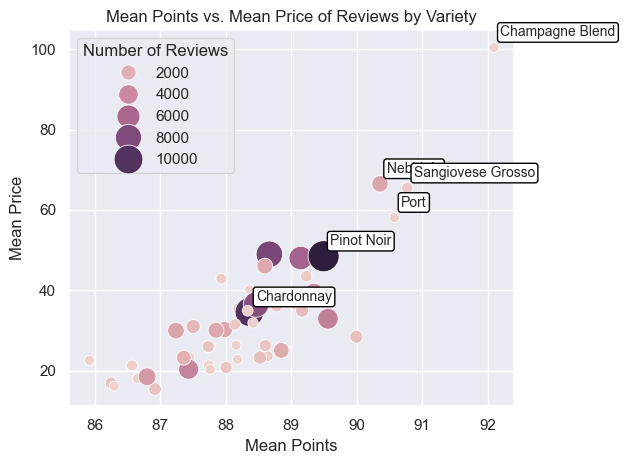

In [121]:
ax = sns.scatterplot(by_variety.reset_index(), x=('points','mean'), y=('price', 'mean'), size=('description', 'count'), sizes=(50,500), hue=('description', 'count'))

# Annotate select points with its label
for i, row in by_variety.reset_index().iterrows():
    if row[('points','mean')] > 90 or row[('description', 'count')] > 10_000:
      # ax.set_ylim(.0, .20)
      ax.text(row[('points','mean')]+.1, row[('price', 'mean')]+2, row['variety'].values[0], fontsize=10,
              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
              horizontalalignment='left', verticalalignment='bottom')
plt.title('Mean Points vs. Mean Price of Reviews by Variety')
plt.ylabel('Mean Price')
plt.xlabel('Mean Points')
plt.legend(title='Number of Reviews')
plt.tight_layout()
plt.show()

#### Conclusion
- Only $4$ varieties reviewed have a mean points value at or above $90$.
- the 2 most reviewed wines are Pinot Noir and Chardonnay.

## Summary
- `Winery` and `Price` are indeed strong predictors of `points`. In blind tastings, these are withheld from tasters to avoid bias. These fields will be withheld from features to replicate the blind tasting process.
- Review length appears to be a predictor of `points`, and may be related to words required to explain the nuances of what makes a highly rated wine remarkable. This data will be added to the features.
- Fewer `ratings` appear to be better separated than `points` categories by review length. We will consider using ratings as the target variable instead of `points`

## Next
- [Feature Selection](feature-selection.ipynb)